In [1]:
from IPython.display import HTML
from IPython.display import display
#Allows the reader to hide/show the code cells. From https://pastebin.com/H77xP2vN
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [231]:
#The first thing to do is importing the libraries and reading in the files
import csv

import numpy as np
import pandas as pd

import re

import time
from datetime import datetime

import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.draw.dispersion import dispersion_plot
from collections import Counter


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn;
from matplotlib.pyplot import figure
import matplotlib
from matplotlib.cm import get_cmap

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import warnings
warnings.filterwarnings("ignore")

In [3]:
#Read the files
transcripts = pd.read_csv('C:\\Users\\andre\\us-supreme-court-cases\\final_case_transcripts.csv')
justices = pd.read_csv('C:\\Users\\andre\\us-supreme-court-cases\\court_justices.csv')

Besides the text spoken, the transcripts data frame contains the case name, a title, the speaker and some time information. For this project, only the case name, speaker, text, and date are required.

In [4]:
transcripts.drop('link', axis=1, inplace=True) #remove the link

In [5]:
transcripts.head()

,case_name,title,speaker,start,stop,duration,text
0,14 Penn Plaza LLC v. Pyett,"Oral Argument - December 01, 2008",Anthony M. Kennedy,282.130,306.527,24.40,"I don't -- I don't wish to delay your reading,..."
1,14 Penn Plaza LLC v. Pyett,"Oral Argument - December 01, 2008",Anthony M. Kennedy,306.527,311.211,4.68,"Now, whether or not it's properly raised here,..."
2,14 Penn Plaza LLC v. Pyett,"Oral Argument - December 01, 2008",Anthony M. Kennedy,311.211,314.495,3.28,But isn't it a factor that we must necessarily...
3,14 Penn Plaza LLC v. Pyett,"Oral Argument - December 01, 2008",Anthony M. Kennedy,1082.991,1092.533,9.54,"Well, that -- that means that -- and if there'..."
4,14 Penn Plaza LLC v. Pyett,"Oral Argument - December 01, 2008",Anthony M. Kennedy,1092.533,1096.487,3.95,The employer hasn't gotten very much.


In [6]:
print(f'The transcripts data frame contains {len(transcripts)} rows')

The transcripts data frame contains 3604605 rows


In order to analyse word usage for different, the text is grouped by the speaker column. As in the future I may wish to analyze how text usages differs on a case to case basis, I'm grouping it by the case name too.     

For the first part of the analysis, the date won't be needed. After grouping everything and removing unwated columns, the data looks like this:

In [7]:
def group_text_and_speaker(column_name, transcripts):
    case_name = transcripts[column_name][0]
    text = transcripts['text'][0]
    speaker = transcripts['speaker'][0]

    text_list = [] # list of all the transcripts
    case_list = []# list of case corresponding to each transcript
    speaker_list = []# list of each speaker corresponding to each transcript
    i = 1 

    while i < len(transcripts):
        if transcripts[column_name][i] == case_name: #check the case is the same as the row above

            if transcripts['speaker'][i] == speaker: #if it is, check whether the speaker has changed
                text += str(transcripts['text'][i]) # if it hasn't, add the current transcript to the full transcript variable
            else:
                text_list.append(text) # if a new speaker is talking, append the current text to the transcripts list
                case_list.append(transcripts[column_name][i - 1])
                speaker_list.append(transcripts['speaker'][i - 1])# and append the speaker's name to the list
                text = transcripts['text'][i] # and initialize a new transcript

        else:
            text_list.append(text) # same for if there's a new case
            text = transcripts['text'][i]

            case_list.append(transcripts[column_name][i - 1])

            case_name = transcripts[column_name][i] # if the row contains a new case, change the case_name variable
            speaker_list.append(transcripts['speaker'][i - 1])

        speaker = transcripts['speaker'][i] #change the speaker to the current's row speaker
        i+=1

    transcripts_ = pd.DataFrame(list(zip(case_list, speaker_list, text_list)), 
                   columns =[column_name, 'speaker', 'text']) # once we have the desired lists, combine them into a new data frame
    return transcripts_

column_name = 'case_name'
transcripts_ = group_text_and_speaker(column_name, transcripts)
transcripts_.tail()

,case_name,speaker,text
67782,"eBay Inc. v. MercExchange, L.L.C.",Jeffrey P. Minear,"Thank you, Mr. Chief Justice, and may it pleas..."
67783,"eBay Inc. v. MercExchange, L.L.C.","John G. Roberts, Jr.",We'll hear argument next in eBay v. MercExchan...
67784,"eBay Inc. v. MercExchange, L.L.C.",John Paul Stevens,But it denies the right subject to being a dam...
67785,"eBay Inc. v. MercExchange, L.L.C.",Ruth Bader Ginsburg,Is that all in Judge Bryson's decision?I certa...
67786,"eBay Inc. v. MercExchange, L.L.C.",Seth P. Waxman,"Mr. Chief Justice, and may it please the Court..."


The most common ones are mostly function words and generally the most used words in the english language. In natural language processing (NLP) these are called 'stop words', and need to be removed.

A graph showing most frequent words and their count:

In [8]:
def get_words(transcripts_):
    all_words=[]
    for text in transcripts_['text']:
        tokenized_word=word_tokenize(text)
        all_words.append(tokenized_word)
    #the output of this for loop is a list of lists, but we need a list of words    
    flat_words = [text for transcript in all_words for text in transcript]
    lower_words = [w.lower() for w in flat_words]#remove any capitalization
    return (lower_words)
lower_words = get_words(transcripts_)

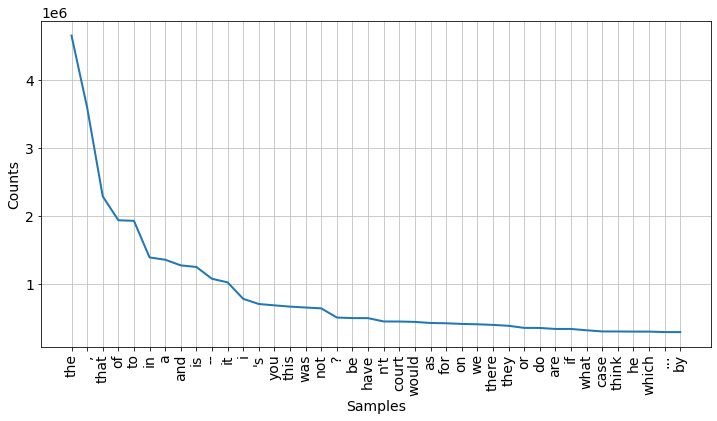

In [9]:
def freq_plot(words):
    fdist = FreqDist(words)   

    figure(num=None, figsize=(12, 6))

    font = {'size'   : 14}
    matplotlib.rc('font', **font)

    fdist.plot(40,cumulative=False)
    plt.show()
freq_plot(lower_words)

Below stopwords and punctuation is removed and the word's lemma is obtained.
"A lemma is a form of a word that appears as an entry in a dictionary and is used to represent all the other possible forms 
(Cambridge Dictionary)"

The most common words graph becomes:

In [10]:
stop_words=set(stopwords.words("english")) # get the stop words using nltk library
filtered_words=[]
for w in lower_words:
    if w.isalnum():
        if w not in stop_words:
            filtered_words.append(w)

final_words = []
lem = WordNetLemmatizer()
for word in filtered_words:
    final_words.append(lem.lemmatize(word,"v"))

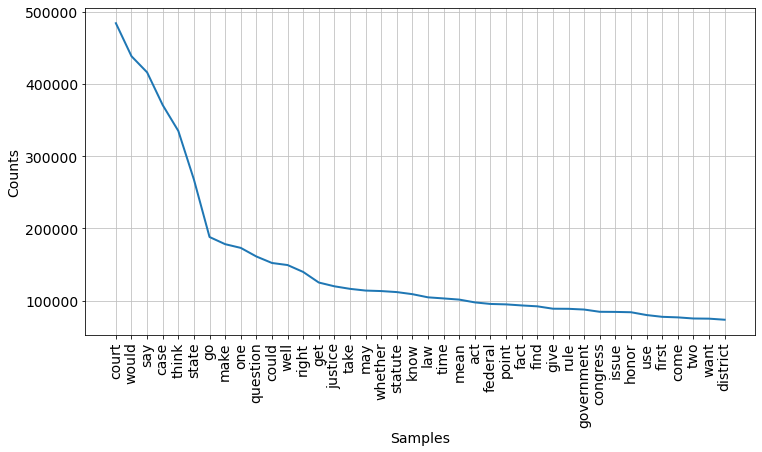

In [11]:
freq_plot(final_words)

A Lexical dispersion plot shows how words are used throught the whole data set. A smooth line indicates that the word is 
utilised fairly evenly, that it's either a common part of speech or a reocurring theme present in all cases, such as 'law' or
'federal'.

Out of the most 500 frequent words plotted below, most of them have high dispersion. 

The most frequent words without a smooth dispersion line are 'tax' and 'jury'. A further analysis on the topic frequency based on word frequency, could look at removing all the words with ver high dispersion.

In [12]:
counter = Counter(final_words) #this returns a touple with the word and its count
most_occur = counter.most_common(500)#get k most frequent words
freq_words = [word for word, count in most_occur]#get a list with just the words

string_words =' '.join(final_words)#turn the word list into a string

tokens = nltk.word_tokenize(string_words)#tokenize the text
mytext = nltk.Text(tokens) # turn text into a NLTK Text object

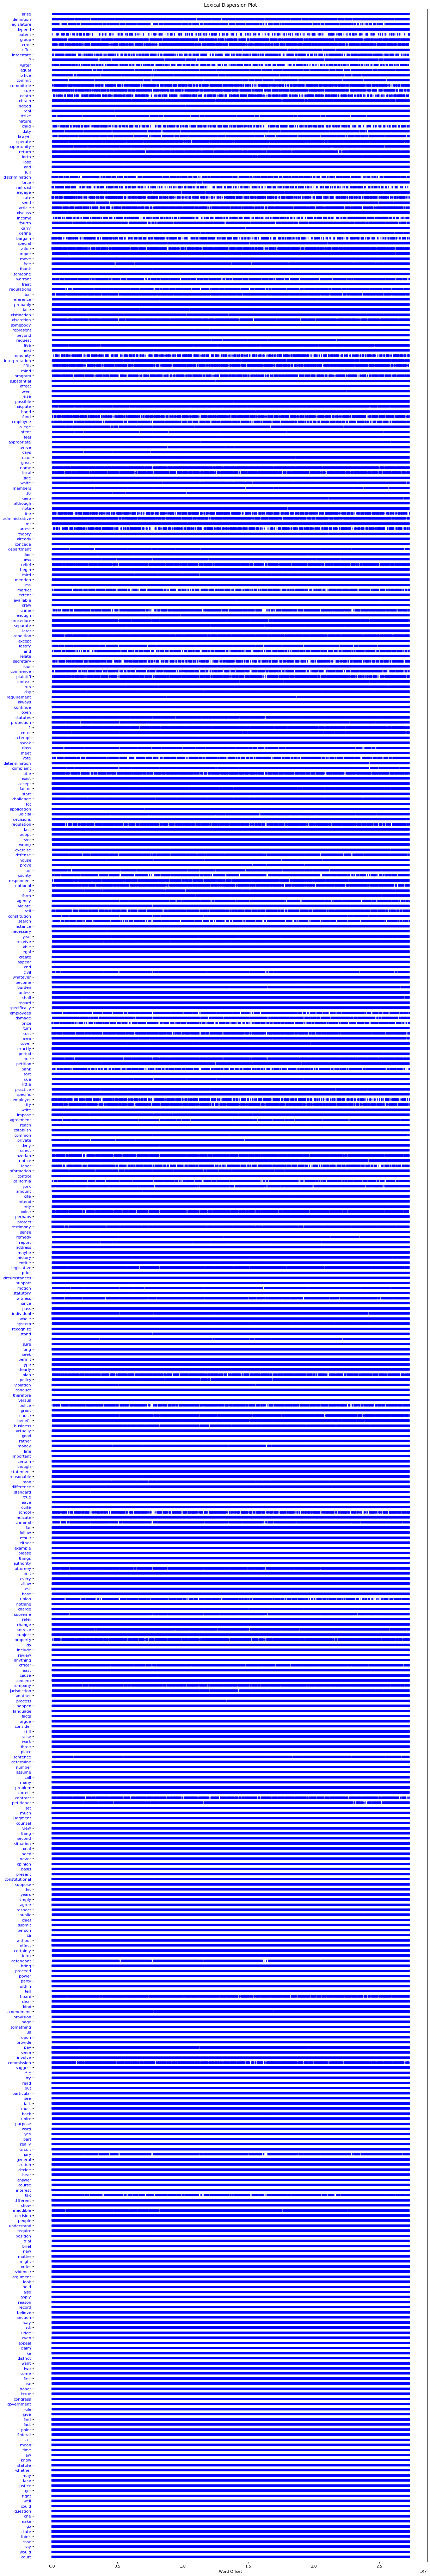

In [235]:
HTML("""
<style>

/* width */
::-webkit-scrollbar {
  width: 5px;
}

/* Track */
::-webkit-scrollbar-track {
  background: #f1f1f1;
}

/* Handle */
::-webkit-scrollbar-thumb {
  background: #888;
}

/* Handle on hover */
::-webkit-scrollbar-thumb:hover {
  background: #555;
}

</style>
""")

figure(num=None, figsize=(18, 120), dpi=80, facecolor='w', edgecolor='k')

mytext.dispersion_plot(freq_words)


The most frequent occurences are mainly specific words for the court environment, and they are of no use when trying to observe any patterns,so I've decided to remove them. 

While I remove the most common 5 words, this is an arbitrary chosen value, and analysis with much more words removed could prove to be more insightful. 

Now that we've seen the most commonly spoken words in court, let's have at look at whether any differences in word usage by the justices can be observed.

In [14]:
justices.head()

,name,oyez_link,wikipedia_link,gender,place_of_birth,place_of_death,interred,origin,race,religion,...,succeeded_by,start_date,end_date,date_of_birth,date_of_death,date_appointed,date_commissioned,date_sworn_in,is_ethnic,seat
0,Abe Fortas,https://www.oyez.org/justices/abe_fortas,https://en.wikipedia.org/wiki/Abe_Fortas,male,"Memphis, TN",NaN,NaN,English,white,Jewish,...,Harry A. Blackmun,1965-10-04 00:00:00 +0000 UTC,1969-05-14 00:00:00 +0000 UTC,1910-06-19 00:00:00 +0000 UTC,1982-04-05 00:00:00 +0000 UTC,NaN,1965-08-11 00:00:00 +0000 UTC,1965-10-04 00:00:00 +0000 UTC,0,1.0
1,Alfred Moore,https://www.oyez.org/justices/alfred_moore,https://en.wikipedia.org/wiki/Alfred_Moore,male,"Brunswick County, NC",NaN,NaN,English/Irish,white,Episcopalian,...,William Johnson,1800-04-21 00:00:00 +0000 UTC,1804-01-26 00:00:00 +0000 UTC,1755-05-21 00:00:00 +0000 UTC,1810-10-15 00:00:00 +0000 UTC,NaN,1799-12-10 00:00:00 +0000 UTC,1800-04-21 00:00:00 +0000 UTC,0,1.0
2,Anthony M. Kennedy,https://www.oyez.org/justices/anthony_m_kennedy,https://en.wikipedia.org/wiki/Anthony_Kennedy,male,"Sacramento, CA",NaN,NaN,Irish,white,Roman Catholic,...,NaN,1988-02-18 00:00:00 +0000 UTC,2018-07-31 00:00:00 +0000 UTC,1936-07-23 00:00:00 +0000 UTC,NaN,NaN,1988-02-11 00:00:00 +0000 UTC,1988-02-18 00:00:00 +0000 UTC,0,1.0
3,Antonin Scalia,https://www.oyez.org/justices/antonin_scalia,https://en.wikipedia.org/wiki/Antonin_Scalia,male,"Trenton, NJ","Shafter, TX",NaN,Italian,white,Roman Catholic,...,NaN,1986-09-26 00:00:00 +0000 UTC,2016-02-13 00:00:00 +0000 UTC,1936-03-11 00:00:00 +0000 UTC,2016-02-13 00:00:00 +0000 UTC,NaN,1986-09-25 00:00:00 +0000 UTC,1986-09-26 00:00:00 +0000 UTC,0,1.0
4,Arthur J. Goldberg,https://www.oyez.org/justices/arthur_j_goldberg,https://en.wikipedia.org/wiki/Arthur_Goldberg,male,"Chicago, IL",NaN,NaN,Russian,white,Jewish,...,Abe Fortas,1962-10-01 00:00:00 +0000 UTC,1965-07-25 00:00:00 +0000 UTC,1908-08-08 00:00:00 +0000 UTC,1990-01-19 00:00:00 +0000 UTC,NaN,1962-09-28 00:00:00 +0000 UTC,1962-10-01 00:00:00 +0000 UTC,0,1.0


In [15]:
justices_names = justices['name'].unique() #gets all the individual names

for i,name in enumerate(transcripts_['speaker']):#update the transcripts data frame to contain only the text spoken by justices
    if name not in justices_names:
        transcripts_.drop(i, inplace=True)

In [16]:
lower_words = get_words(transcripts_)

In [17]:
ext_list = ['court','would','say','case','think']
def final_edit(lower_words):
    stop_words=stopwords.words("english") # get the stop words using nltk library
    stop_words.extend(ext_list)
    #even though the word 'say' is removed, words such as 'said' are still allowed to passed, which is why after lemmatizing
    #the word 'say' is the most popular
    filtered_words=[]
    for w in lower_words:
        if w.isalnum():
            if w not in stop_words:
                filtered_words.append(w)
                
    return filtered_words

final_words = final_edit(lower_words)

After removing the words 'court','would','say','case' and 'think' from the list, this is the word frequency graph for the justices:

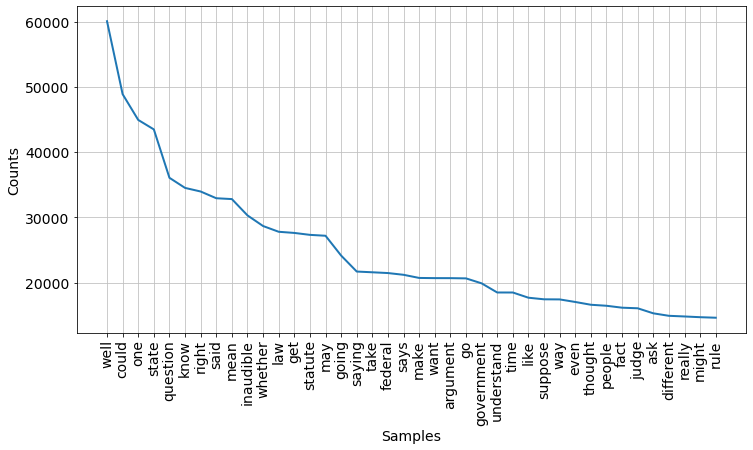

In [18]:
freq_plot(final_words)

While the word frequency rankings are fairly similar, there are a couple of differences, the most notable ones being:
<ol>
<li>The word 'go' is used far less, dropping from 2nd position (once removing the top 5 words) to 34th.</li>
    <li>'Fact' and'Government' are more frequently used by justices than the average speaker.</li>
    <li> 'Honor' appears in the top 40 list of all speakers, however doesn't show on the justices graph. This probably happens as judges are called 'Your Honor' by the other speakers. </li>
    
</ol>

Below is a word cloud of the most 200 common words spoken by the justices. Keep in mind that the purpose of this image is for a nice visualization of the overeall frequencies, as opposed to the accuracy of the graph above. 

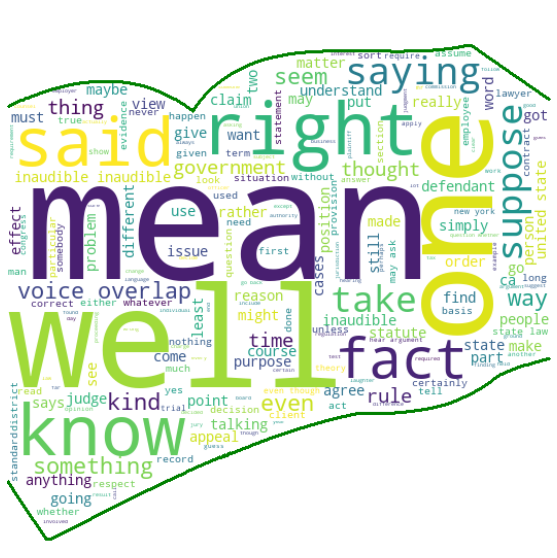

In [19]:
final_str = ' '.join(final_words)#word cloud takes in string type

book_mask = np.array(Image.open("C:\\Users\\andre\\OneDrive\\Pictures\\book_mask.png")) #import a book shaped mask
    
# Create a word cloud image
wc = WordCloud(background_color="white", max_words=200, mask=book_mask,
                contour_width=3, contour_color='green').generate(final_str)

# store to file
wc.to_file("words.png")

plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Next, I compare the Democratic and Republican justices

In [20]:
justices_in_dataset = transcripts_['speaker'].tolist()#a list of all the court room speakers
justices_set = set(justices_in_dataset)
unique_names = list(justices_set)#use conversion to set and back to list to get distinct names

In [21]:
for i, name in enumerate(justices['name']):
    if name not in unique_names:#drop the names which do not belong to any of the justices
        justices.drop(i, inplace = True)

In [22]:
case_list= transcripts['case_name'].tolist()
case_list = list(set(case_list))
speaker_list= list(set(transcripts['speaker'].tolist()))
text_list= transcripts_['text'].tolist()

In [23]:
justices_final =  pd.DataFrame(list(zip(case_list, speaker_list, text_list)))#create a new data frame to contain the text
#spoken by jsutices and the corresponding cases names

justices_final = pd.concat([justices['name'], justices['appointing_party'], justices['start_affiliation'], 
                            justices['party_switch_year']], axis =1)

justices_final = justices_final.reset_index()#reset the index

justices_final.drop(['index'], axis=1, inplace=True)#drop the old index

justices_final

,name,appointing_party,start_affiliation,party_switch_year
0,Abe Fortas,Democratic,NaN,NaN
1,Anthony M. Kennedy,Republican,NaN,NaN
2,Antonin Scalia,Republican,NaN,NaN
3,Arthur J. Goldberg,Democratic,NaN,NaN
4,Brett M. Kavanaugh,Republican,NaN,NaN
5,Byron R. White,Democratic,NaN,NaN
6,Charles E. Whittaker,Republican,NaN,NaN
7,Clarence Thomas,Republican,NaN,NaN
8,David H. Souter,Republican,NaN,NaN
9,Earl Warren,Republican,NaN,NaN


John M. Harlan is in the data frame, however he died in 1911. It's his grandson, John M. Harlan II, who was a jurist between 1955 and 1971.

Sonia Sotomayor was an independent, however she switched to the Democratic Party in the same year that she was appointed by Barack Obama, thus she will be considered a Democrat for the purposes of this project.

From 1956 through to 2018, there have been 15 Republican justices and 15 Democrats in office.

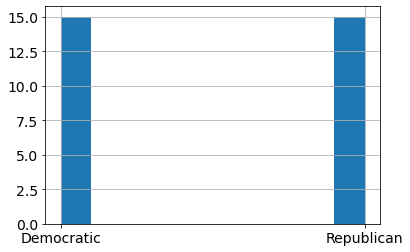

In [24]:
justices_final.drop(15, inplace=True)# remove John M. Harlan from the list 
justices_final['appointing_party'].hist()

In [25]:
justices_final.drop(['start_affiliation'], axis = 1, inplace=True)
justices_final.drop(['party_switch_year'], axis = 1, inplace=True)

In [30]:
justices_final.rename(columns={'name':'speaker'},inplace = True)#rename the column to have the same name as the transcripts
#column, to be able to join on it

In [31]:
transcripts_.reset_index(inplace= True)

transcripts_.drop(['index'], axis=1, inplace = True)

transcripts_updated = pd.merge(justices_final, transcripts_, on='speaker')#perform an inner join of the justices_final and 
#transcripts_ data frame, on the speaker column

Plotting how many times Democrats and Republicans have spoken, it appears that Republicans have been more vocal, having taken 
their turn to speak almost 10 thousand times more than the Democrats, amounting to ~ 66% more dialog.

Text(0.5, 0, 'Party')

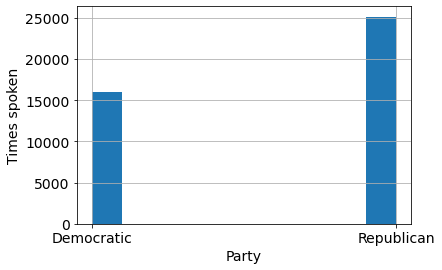

In [32]:
ax = transcripts_updated['appointing_party'].hist()
ax.set_ylabel('Times spoken')
ax.set_xlabel('Party')

In [33]:
def get_words_party(transcripts_, party):
    all_words=[]
    for i,text in enumerate(transcripts_['text']):
        if transcripts_['appointing_party'][i] == party:#get the words only for democratic justices
            tokenized_word=word_tokenize(text)
            all_words.append(tokenized_word)
    #the output of this for loop is a list of lists, but we need a list of words    
    flat_words = [text for transcript in all_words for text in transcript]
    lower_words = [w.lower() for w in flat_words]#remove any capitalization
    return (lower_words)

party = 'Democratic'
lower_words_democratic=get_words_party(transcripts_updated, party)
final_words_dem= final_edit(lower_words_democratic)

Word frequency of Democratic Justices:

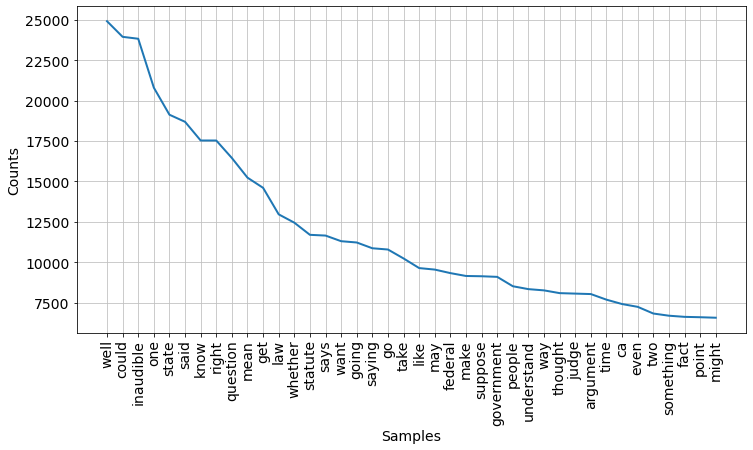

In [34]:
freq_plot(final_words_dem)

In [36]:
party = 'Republican'
lower_words_republican=get_words_party(transcripts_updated, party)
final_words_rep = final_edit(lower_words_republican)

Word frequency of Republican Justices:

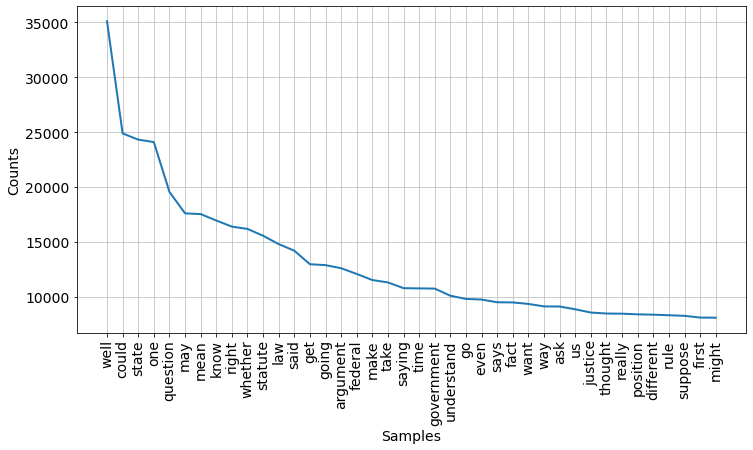

In [37]:
freq_plot(final_words_rep)

Although the two graphs are mostly similar, there are some distinctions: <ol>
    <li>Oddly, there were a lot times when words spoken by a Democrat were inaudible: ~23,000 occurences. Further investigation
        might reveal whether this happened because of specific cases(s) or speaker(s). </li>
    <li>'like' is the 21st most used word by Democrats, yet doesn't feature in top 40 for Republicans </li>
    <li>'argument' is used significantly more by Republicans (15th most frequent) compared to Democrats (32nd)</li>

In [38]:
print ('The number of words used by justices appointed as Democratic is ' +str(len(lower_words_democratic)/10**6) +' million')
print ('The number of words used by justices appointed as Republican is  ' + str(len (lower_words_republican)/10**6) +' million')

The number of words used by justices appointed as Democratic is 7.771705 million
The number of words used by justices appointed as Republican is  9.373765 million


Although Republicans have spoken ~ 66% more times than Democrats, after removing the stop words, it seems  they've only said    ~ 20% more words.

In [40]:
final_str_dem = ' '.join(final_words_dem)
final_str_rep = ' '.join(final_words_rep)
print ('The number of characters for Democratic appointed justices is ' +str(len(final_str_dem)/10**6) +' million')
print ('The number of characters for Republican appointed justices is ' + str(len (final_str_rep)/10**6) +' million')

The number of characters for Democratic appointed justices is 18.294039 million
The number of characters for Republican appointed justices is 23.329273 million


When it comes to number of charachters, Republicans have spoken ~5 million more, equal to ~27% more.

Below are word cloud images for the Democratic and Republican justices:

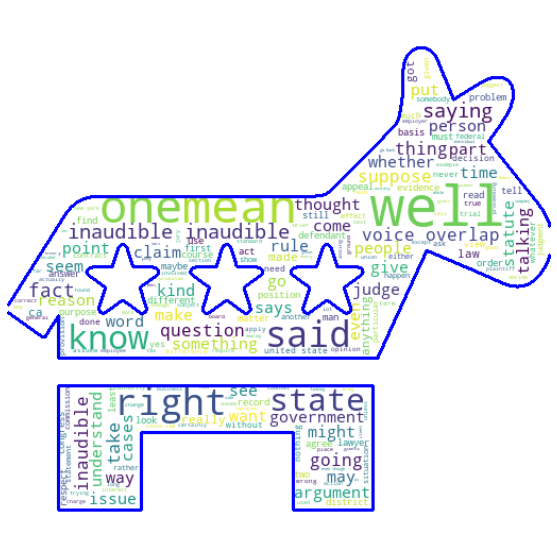

In [41]:
donkey_mask = np.array(Image.open("C:\\Users\\andre\\OneDrive\\Pictures\\donkey.png")) 
    
# Create a word cloud image
wc = WordCloud(background_color="white", max_words=200, mask=donkey_mask,
                contour_width=3, contour_color='blue').generate(final_str_dem)

# store to file
wc.to_file("dem_words.png")

plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

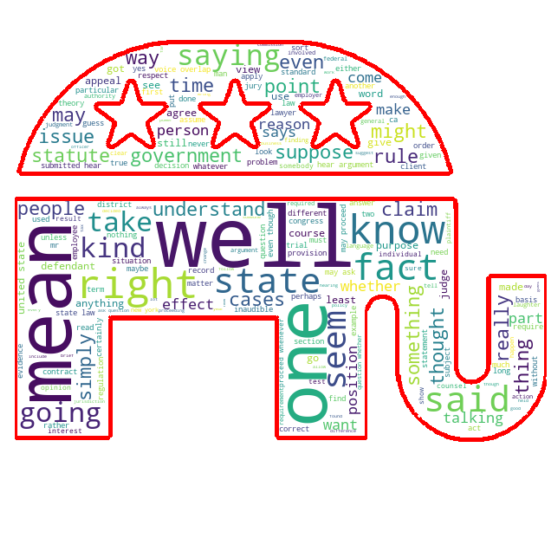

In [42]:
elephant_mask = np.array(Image.open("C:\\Users\\andre\\OneDrive\\Pictures\\elephant.png")) 
    
# Create a word cloud image
wc = WordCloud(background_color="white", max_words=200, mask=elephant_mask,
                contour_width=3, contour_color='red').generate(final_str_rep)

# store to file
wc.to_file("rep_words.png")

plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

For the second part of this project, I will restructure the data and draw a graph of number of words spoken vs date, for all of the 30 justices. 

Data in this format can be used for further analysis, such as looking at what topics have been debated over time, or how sentiment in relation to certain issues has been evolving.

In [43]:
justices['start_date'].tolist()
justices['end_date'].tolist()
justices['name'].tolist()
justices['appointing_party'].tolist()

justices_dates = pd.DataFrame(list(zip(justices['name'].tolist(),
                                       justices['appointing_party'].tolist() ,
                                       justices['start_date'].tolist(), 
                                       justices['end_date'].tolist())), columns =['Name', 'appointing_party', 'start_date','end_date' ])

I change the dates to datetime type

In [44]:
justices_dates.head()

,Name,appointing_party,start_date,end_date
0,Abe Fortas,Democratic,1965-10-04 00:00:00 +0000 UTC,1969-05-14 00:00:00 +0000 UTC
1,Anthony M. Kennedy,Republican,1988-02-18 00:00:00 +0000 UTC,2018-07-31 00:00:00 +0000 UTC
2,Antonin Scalia,Republican,1986-09-26 00:00:00 +0000 UTC,2016-02-13 00:00:00 +0000 UTC
3,Arthur J. Goldberg,Democratic,1962-10-01 00:00:00 +0000 UTC,1965-07-25 00:00:00 +0000 UTC
4,Brett M. Kavanaugh,Republican,2018-10-06 00:00:00 +0000 UTC,NaN


In [46]:
transcripts.drop(['case_name','start','stop','duration'], axis =1, inplace = True)# don't need these columns 

In [47]:
transcripts.rename({'title':'date'}, axis =1, inplace = True)# we only need the date in the title

In [48]:
print ('The number of rows is ' + str(len(transcripts['date'])))

The number of rows is 3604605


In [49]:
oral_arguments=[]
for title in transcripts['date']:
    if 'Oral Argument' in title:
        oral_arguments.append(title)
print ('The number of oral argument types is ' + str(len(oral_arguments)))        

The number of oral argument types is 3604605


So all titles are of 'Oral Argument' type. Since only the the date is needed, this is removed from the title.

In [50]:
date_list = [w.strip('Oral Argument - ') for w in transcripts['date']]# this list holds the values for the new column
transcripts.drop('date', axis =1, inplace = True)#drop the current column
transcripts.insert(0, 'date', date_list)#insert the column containing just the dates

In [51]:
text_date = group_text_and_speaker('date', transcripts)

In [52]:
text_length = [len(text_) for text_ in text_date['text']]#create a new column with the number of words for each piece of text
text_length = pd.DataFrame(text_length)#turn it into a data frame
date_transcripts = text_date.join(text_length)#and join it to the transcripts data frame
date_transcripts.rename({0:'words'}, axis = 1, inplace = True)#name the column title as 'words'

Next, the speakers who are not justices are removed from the data frame.

In [53]:
justices_names = justices_dates['Name'].tolist() #gets all the individual names

for i,name in enumerate(date_transcripts['speaker']):#update the transcripts data frame to contain only the text spoken by justices
    if name not in justices_names:
        date_transcripts.drop(i, inplace=True)

A new data frame is written after grouping the text by speaker and date, removing all speakers who are not justices and adding number of words in each text:

In [54]:
date_transcripts.tail()

,date,speaker,text,words
67776,"ctober 12, 1967",Thurgood Marshall,"Mr. Redfield, who could better determine the p...",1268
67779,"March 29, 2006",Anthony M. Kennedy,"Well, but --Well, I'm -- I interrupted you.But...",1198
67780,"March 29, 2006",Antonin Scalia,Is -- is that so with -- with respect to someo...,3070
67784,"March 29, 2006",John Paul Stevens,But it denies the right subject to being a dam...,1121
67785,"March 29, 2006",Ruth Bader Ginsburg,Is that all in Judge Bryson's decision?I certa...,1189


In [55]:
print (f'{41081/67785 *100:.1f} % of times someone spoke in court, it was one of the justices. ')

60.6 % of times someone spoke in court, it was one of the justices. 


In [56]:
date_transcripts.reset_index(inplace = True)#reset the index
date_transcripts.drop('index', axis =1, inplace = True)#delete the old one

In [57]:
for i, time_info in enumerate(justices_dates['start_date']):#the first 10 characters contain the date 
    justices_dates['start_date'][i] = time_info[:10]

for i, time_info in enumerate(justices_dates['end_date']):
    try:#there are some NaN values for jsutices that were still in office as off the end of 2018; these cells are skipped
        justices_dates['end_date'][i] = time_info[:10]
    except:
        continue

In [58]:
for i, date in enumerate(justices_dates['start_date']):
    justices_dates['start_date'][i] = datetime.strptime(date, '%Y-%m-%d').date()#change the data type to datetime

for i, date in enumerate(justices_dates['end_date']):
    try:# use try/except because of the nan values
        justices_dates['end_date'][i] = datetime.strptime(date, '%Y-%m-%d').date()
    except:
        continue

In [107]:
'''In order to replace to format the date, the pd.replace is used.
First, a list with the months in the current format. The dot at the end makes sure only the month name is changed'''
jan= r'January.'
feb=r'February.'
mar = r'March.'
april = r'April.'
may = r'May.'
june = r'June.'
july = r'July.'
aug = r'August.'
sep = r'September.'
octo = r'October.'
nov = r'November.'
dec = r'December.'
#some of the october and april months are missing the first character.
pril = r'pril.'
ctober = r'ctober.'

#replace the month names with the corresponding digit format:
trans_for_format = date_transcripts.replace(to_replace=[jan,feb, mar, april, may, june, july, aug, sep, octo, nov, dec, pril, ctober],
                         value=['01-','02-','03-','04-','05-','06-','07-','08-','09-','10-','11-','12-','04-','10-'], 
                         regex=True)

In [147]:
print ('This is the format that we want: \nRow 0: ' + str(trans_for_format['date'][0]))
print('\nHowever, some cases have additional information included in the title:\n')
print ('Row 4450: ' + str(trans_for_format['date'][4450]))
print ('Row 18562: ' + str(trans_for_format['date'][18562]))
print ('Row 23800: ' + str(trans_for_format['date'][23800]))

This is the format that we want: 
Row 0: 12-01, 2008

However, some cases have additional information included in the title:

Row 4450: 03-28, 1961 (Part 2)
Row 18562: (No. 14-452) - 10-07, 2015
Row 23800: , Part 2: Moog Industries, Inc. v. FTC - 01-14, 1958 (77)


In order to solve this issue, I useed python's standard regex library.

In [62]:
pattern_beginning = re.compile(r'..-..,.....')# get the date format, for when the date is written in the begginning
pattern_middle = re.compile (r'.* - ')#gets the format for when the date is positioned in the middle
trans_for_format = trans_for_format.replace(to_replace = ['st '], value=['08-'], regex = True)

for i, title in enumerate(trans_for_format['date']):
    result = pattern_beginning.match(title)#check whether there is a match for the pattern
    try:
        trans_for_format['date'][i] = result.group(0)#get the text of the resulting match
    except:
        try:
            trans_for_format['date'][i] = re.split(pattern_middle, trans_for_format['date'][i], maxsplit = 1)[1][:11]
        except:# the only rows which are still not in the desired format, look like this:' , 03-23, 2015'. There is an unwanted
            #comma
            trans_for_format['date'][i] = trans_for_format['date'][i][2:]


In [64]:
for i, date in enumerate(trans_for_format['date']):
    try:#convert to datetime. There are the 2 current formats that the dates are stored in 
        trans_for_format['date'][i] = datetime.strptime(date, '%Y-%m, %d').date()
    except:
        trans_for_format['date'][i] = datetime.strptime(date, '%m-%d, %Y').date()

In [65]:
unconverted = []
print('The new data type for the dates column is ' + str(type(trans_for_format['date'][0])))
for date in trans_for_format['date']:
    if type(date) != type(trans_for_format['date'][0]):#check whether any data types are not datetime
        unconverted.append(date)#and append them to this list
l = len(unconverted)
print(f'There are {l} unconverted dates')

The new data type for the dates column is <class 'datetime.date'>
There are 0 unconverted dates


A table with word count for each speaker by date can now be written. 
Additionally, I'm obtaining a table containing the actual spoken text.

In [67]:
dates_list = list(set(trans_for_format['date'].tolist()))

In [68]:
justices_names.remove('John M. Harlan')

In [69]:
final_df = pd.DataFrame(columns = justices_names, index = dates_list)
df_text = pd.DataFrame(columns = justices_names, index = dates_list)

In [ ]:
# WARNING !!! THIS TAKES A LOT OF TIME TO RUN !!!
#It took me ~45 minutes. I recommend downloading the  file from the repository
#I'm sure there has to be a more efficient way to achieve the same result; so if you have any ideas please let me know !

for speaker in justices_names:# this will loop through all the columns in final_df
    for i, text_on_date in enumerate(final_df[speaker]):#loop through the rows in the column
        for j, date in enumerate(trans_for_format['date']):#loop through data frame with dates and words
            
            #once a date match for the row with the transcripts data frame has been found:
            if final_df.index[i] == date:
                if speaker == trans_for_format['speaker'][j]:#check if the speaker on this column has spoken on this date
                    #if he/she has, then set the row's value as the number of words that the speaker said on this date
                    final_df[speaker][i] = trans_for_format['words'][j]

In [71]:
# WARNING !!! THIS TAKES A LOT OF TIME TO RUN !!!
#It took me ~45 minutes. I recommend downloading the file from the repository
#I'm sure there has to be a more efficient way to achieve the same result; so if you have any ideas please let me know !

for speaker in justices_names:# this will loop through all the columns in final_df
    for i, text_on_date in enumerate(df_text[speaker]):#loop through the rows in the column
        for j, date in enumerate(trans_for_format['date']):#loop through data frame with dates and words
            
            #once a date match for the row with the transcripts data frame has been found:
            if df_text.index[i] == date:
                if speaker == trans_for_format['speaker'][j]:#check if the speaker on this column has spoken on this date
                    #if he/she has, then set the row's value as the text that the speaker said on this date
                    df_text[speaker][i] = trans_for_format['text'][j]

In [133]:
final_df.to_csv('words_count.csv')#write the data frame to a .csv file, in order to avoid having to run the length code above
#I tried using JSON, however the date time data was deteriorated.    

In [134]:
final_df= pd.read_csv('words_count.csv')#read from the .csv file
final_df.set_index('Unnamed: 0',inplace=True)#set the index as the dates
final_df.rename_axis("Date",inplace = True)#and change the name above the indeces to 'Date'

In [77]:
df_text.to_csv('text_data.csv')#the same for the data frame containing the text

In [101]:
df_text = pd.read_csv('text_data.csv')#read text_data from .csv file
df_text.set_index('Unnamed: 0', inplace =True)
df_text.rename_axis('Date', inplace = True)
df_text.index = pd.to_datetime(df_text.index)
df_text.fillna(0,inplace = True)

In [103]:
df_text.index = pd.to_datetime(df_text.index)

In [105]:
df_text.sort_index(ascending = True, inplace = True)

In [106]:
df_text.head()

,Abe Fortas,Anthony M. Kennedy,Antonin Scalia,Arthur J. Goldberg,Brett M. Kavanaugh,Byron R. White,Charles E. Whittaker,Clarence Thomas,David H. Souter,Earl Warren,...,Sandra Day O'Connor,Sherman Minton,Sonia Sotomayor,Stanley Reed,Stephen G. Breyer,Thurgood Marshall,Tom C. Clark,Warren E. Burger,William H. Rehnquist,William O. Douglas
Date,,,,,,,,,,,,,,,,,,,,,
1956-01-24,0,0,0,0,0,0,0,0,0,"105, William Thompson versus Coastal Oil Compa...",...,0,Is this (Voice Overlap) --Is there a question ...,0,But the application of unseaworthiness to the ...,0,0,0,0,0,0
1956-10-08,0,0,0,0,0,0,0,0,0,"Number 6, Oleta O'Connor Yates, Henry Steinber...",...,0,0,0,0,0,0,0,0,0,What's the page number?
1956-10-09,0,0,0,0,0,0,0,0,0,"Mr. Margolis you may proceed.Mr. Margolis, did...",...,0,0,0,0,0,0,0,0,0,Let's ju08-talk about overt acts?I say what is...
1956-10-10,0,0,0,0,0,0,0,0,0,"Number 15, Oleta O'Connor Yates, Petitioner, v...",...,0,0,0,0,0,0,Did she answer any question as to other Commun...,0,0,But what -- what they did was (Inaudible) know...
1956-10-11,0,0,0,0,0,0,0,0,0,Does it come over the Government pier in the s...,...,0,0,0,(Inaudible) delivered its stuff to the Governm...,0,0,"That's what the judge said, you haven't laid a...",0,0,(Inaudible)


In [135]:
final_df.index = pd.to_datetime(final_df.index)#turn the index data type back into a time format

In [136]:
final_df.fillna(0, inplace= True)
final_df.head()

,Abe Fortas,Anthony M. Kennedy,Antonin Scalia,Arthur J. Goldberg,Brett M. Kavanaugh,Byron R. White,Charles E. Whittaker,Clarence Thomas,David H. Souter,Earl Warren,...,Sandra Day O'Connor,Sherman Minton,Sonia Sotomayor,Stanley Reed,Stephen G. Breyer,Thurgood Marshall,Tom C. Clark,Warren E. Burger,William H. Rehnquist,William O. Douglas
Date,,,,,,,,,,,,,,,,,,,,,
1956-01-24,0,0,0,0,0,0,0,0,0,771,...,0,86,0,1133,0,0,0,0,0,0
1956-11-05,0,0,0,0,0,0,0,0,0,274,...,0,0,0,0,0,0,502,0,0,83
1956-11-06,0,0,0,0,0,0,0,0,0,184,...,0,0,0,387,0,0,0,0,0,199
1956-11-07,0,0,0,0,0,0,0,0,0,42,...,0,0,0,130,0,0,275,0,0,147
1956-11-13,0,0,0,0,0,0,0,0,0,740,...,0,0,0,119,0,0,330,0,0,41


A plot with word count per year for all the justices is drawn below . It indicates that they show very different levels of involvment when it comes to speaking in court. Felix Frankfurter, who was the most outspoken advocate of judicial restraint at the time*, takes the lead of most words spoken, with over 7000 in 1957.

*(Semonche, John E. "A People's History of the Supreme Court." The Journal of American History 87.2 (2000): 634.)

In [224]:
def plot_words(speaker, final_df, clr): 
    ax = final_df[speaker].resample('BA').mean().plot(figsize= (10,6), color =(clr))# get the average words spoken each year
    #and draw the graph.Set the color of the graph
    
    ax.legend(loc='upper center', bbox_to_anchor=(1.4, 0.7), shadow=True, ncol=2)#plot the legend on 2 columns
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of words spoken')

    font = {'size' : 12}
    matplotlib.rc('font', **font)
    
    leg = ax.get_legend()
    plt.ylim(0, 7500)
    return leg

In [225]:
colors = [i for i in get_cmap('tab20').colors]#using the tab20 cmap for the legends

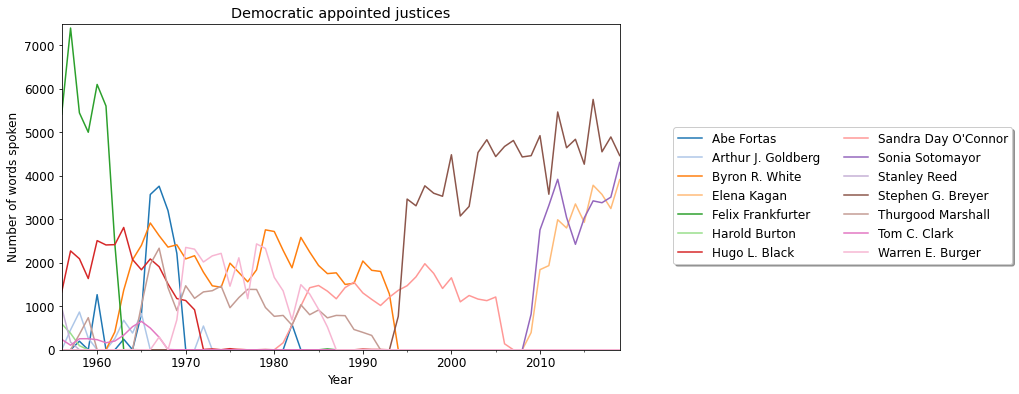

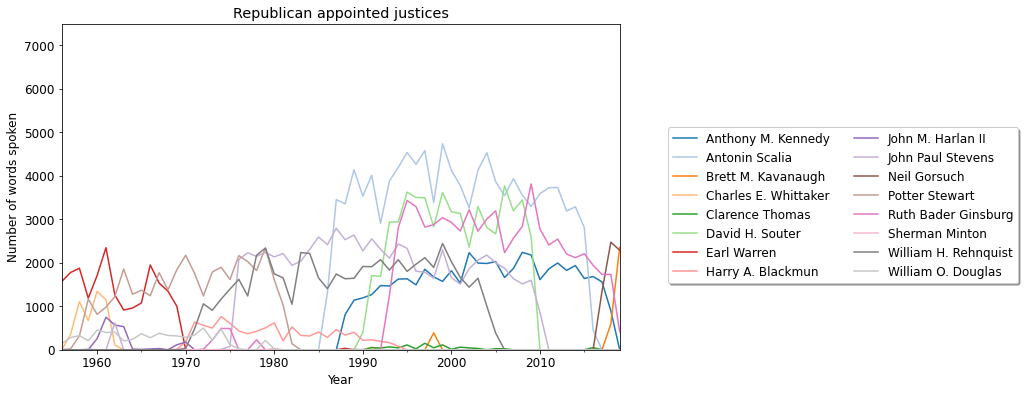

In [227]:
d=0#use these to loop through the colors for the legends
r=0
for i, speaker in enumerate(justices_names):# loop through the speakers names
    if justices_dates['appointing_party'][i] == 'Democratic':#draw 2 figures, one for Dem appointed justices, one for Rep.
        plt.figure(1)#plot on the 'Democratic Party' figure
        
        clr_dem = colors[d]#get the graph color
        plot_words(speaker, final_df,clr_dem)
        d+=1#move to the next color in the list
        
        plt.title('Democratic appointed justices')

    else:
        plt.figure(2)
        
        clr_rep = colors[r]
        plot_words(speaker, final_df,clr_rep)
        r+=1
        
        plt.title('Republican appointed justices')

I hope you found this project interesting !

What is probably most exciting about this dataset is the room for further analysis. Some questions to consider approaching are:
<ul>
    <li> How have the case topics been changing since 1956 ? </li>
    <li> How has the way people convey their message in court changed ? </li> </ul>
 
Thanks for reading! If you have any comments or suggestions, please feel free to let me know !